In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import im2col_conv, col2im_conv, im2col_conv_batch

In [2]:
#GLOBALS
resultsdir = '../results'
os.makedirs(resultsdir, exist_ok=True)

In [ ]:
def display_results_2(input_data, output, params, testname):
    global resultsdir
    
    fig, ax = plt.subplots(input_data['batch_size'], 1)
    for batch in range(input_data['batch_size']):
        # outputs
        img = output['data'][:,batch].reshape(output['height'], output['width'])
        
        # middle
        img = np.hstack([params['w'].T, np.ones(img.shape), params['b'].reshape(-1, 1), np.zeros(img.shape), img])
        
        # inputs
        imgin = input_data['data'][:,batch].reshape(input_data['height'], input_data['width']).T
        imgin_padded = np.hstack([imgin, np.zeros((imgin.shape[0], 4))])
        img = np.vstack([imgin_padded, np.zeros(imgin_padded.shape), np.zeros(imgin_padded.shape), np.ones(imgin_padded.shape), img])
        
        ax[batch].imshow(img)
        ax[batch].set_title(f'Batch {batch + 1}')
        ax[batch].set_axis_off()
        
    fig.suptitle(testname)
    
    filename = f"{resultsdir}/{testname}.png"
    plt.savefig(filename)

In [ ]:
def inner_product_forward(input, layer, param):
    """
    Forward pass of inner product layer.

    Parameters:
    - input (dict): Contains the input data.
    - layer (dict): Contains the configuration for the inner product layer.
    - param (dict): Contains the weights and biases for the inner product layer.
    """

    d, k = input["data"].shape
    n = param["w"].shape[1]

    ###### Fill in the code here ######
    W = param["w"]
    X = input["data"]
    b = param["b"]
    
    f = np.dot(W.T,X) + b.T
    
    # Initialize output data structure
    output = {
        "height": n,
        "width": 1,
        "channel": 1,
        "batch_size": k,
        "data": f #np.zeros((n, k)) # replace 'data' value with your implementation
    }

    return output

In [ ]:
def test_inner_1():
    # Initialize the 'input' structure
    input_data = {}
    input_data['data'] = np.zeros((25,2))
    input_data['data'] = input_data['data'].T
    input_data['data'].flat[5::3] = 1.0
    input_data['data'].flat[6::3] = 0.5
    input_data['data'] = input_data['data'].T
    input_data['height'] = 25
    input_data['width'] = 1
    input_data['channel'] = 1
    input_data['batch_size'] = 2

    # Initialize the 'layer' structure
    layer = {}
    layer['type'] = 'IP'
    layer['num'] = 25

    # Initialize the 'params' structure
    params = {}
    params['w'] = np.eye(25)
    params['w'].flat[:25*10] = 0
    params['w'][1, 4] = 0.5
    params['w'][2, 3] = 0.5
    params['b'] = np.zeros((1,25))
    params['b'][0,1] = 0.5
    params['b'][0,3] = 0.5

    output = inner_product_forward(input_data, layer, params)

    display_results_2(input_data, output, params, 'Inner Product Test')

In [ ]:
def test_pooling_1():
    input_data = {'data': np.zeros((36*3,2))}
    input_data['data'][12, 0] = 0.5
    input_data['data'][13, 0] = 0.25
    input_data['data'][14, 0] = 0.5
    input_data['data'][19+72, 0] = 0.75

    input_data['data'][14, 1] = 0.25
    input_data['data'][15, 1] = 0.75
    input_data['data'][5+36, 1] = 0.75
    input_data['data'][11+72, 1] = 0.75
    input_data['width'] = 6
    input_data['height'] = 6
    input_data['channel'] = 3
    input_data['batch_size'] = 2

    layer = {'type': 'POOLING', 'k': 2, 'stride': 2, 'pad': 0}

    output = pooling_layer_forward(input_data, layer)
    display_results(input_data, output, 'Pooling Test')

In [31]:
def display_results(input_data, output, testname):
    global resultsdir
    
    fig, ax = plt.subplots(input_data['batch_size'], 2)
    for batch in range(input_data['batch_size']):
        # outputs
        img1 = output['data'][:,batch].reshape(output['channel'], output['height'], output['width'])
        img1 = np.transpose(img1, (1, 2, 0))
        ax[batch, 1].imshow(img1)
        ax[batch, 1].set_title(f'Output {batch + 1}')
        ax[batch, 1].set_axis_off()

        # inputs
        imgin1 = input_data['data'][:,batch].reshape(input_data['channel'], input_data['height'], input_data['width'])
        imgin1 = np.transpose(imgin1, (1, 2, 0))
        ax[batch, 0].imshow(imgin1)
        ax[batch, 0].set_title(f'Input {batch + 1}')
        ax[batch, 0].set_axis_off()

    fig.suptitle(testname)
    
    filename = f"{resultsdir}/{testname}.png"
    plt.savefig(filename)

In [ ]:
def pooling_layer_forward(input, layer):
    """
    Forward pass for the pooling layer.

    Parameters:
    - input (dict): Contains the input data.
    - layer (dict): Layer configuration containing parameters such as kernel size, padding, stride, etc.
    """
    
    h_in = input['height']
    w_in = input['width']
    c = input['channel']
    batch_size = input['batch_size']
    k = layer['k']
    pad = layer['pad']
    stride = layer['stride']

    h_out = int((h_in + 2 * pad - k) / stride + 1)
    w_out = int((w_in + 2 * pad - k) / stride + 1)
    
    ###### Fill in the code here ######
    output_data = np.zeros((c*h_out*w_out,batch_size))

    for batch in range(batch_size):
        #input image reshaped
        img = input['data'][:,batch].reshape(c, h_in, w_in) #need to account for padding

        # add padding if it exists
        pad_img = np.zeros((c,pad*2+h_in,pad*2+w_in))
        for chan in range(c):
            pad_img[chan] = np.pad(img[chan],pad)

        #matrix to hold the pooled layers
        pool_mtx = np.zeros((c,h_out,w_out))

        #slide kernel across pad_img and grab max

        row = 0
        col = 0 #to control the pool_mtx row and col to be filled in
        #go across rows with j
        for j in range(0,pad_img.shape[1],stride): #stride is 2

            col = 0 #reset column for next row

            #go across columns with i
            for i in range(0,pad_img.shape[2],stride):

                #go across channels
                for chan in range(c):
                    #grab max from the kernel slice of image mtx
                    pool_mtx[chan,row,col] = np.max(pad_img[chan,j:j+stride,i:i+stride])

                col = col + 1 # move on to the next coumn

            row = row + 1 # increment row when columns are done

        output_data[:,batch] = pool_mtx.reshape(1,c*h_out*w_out)[0]
    
    output = {}
    output['height'] = h_out
    output['width'] = w_out
    output['channel'] = c
    output['batch_size'] = batch_size
    output['data'] = output_data#np.zeros((h_out, w_out, c, batch_size)) # replace with your implementation

    return output

In [ ]:
test_inner_1()

In [ ]:
test_pooling_1()

### Convolution Test

In [ ]:
def conv_layer_forward(input_data, layer, param):
    """
    Forward pass for a convolutional layer.

    Parameters:
    - input_data (dict): A dictionary containing the input data.
    - layer (dict): Layer configuration containing parameters such as kernel size, padding, stride, etc.
    - param (dict): A dictionary containing the parameters 'b' and 'w'.
    """
    h_in = input_data['height']
    w_in = input_data['width']
    c = input_data['channel']
    batch_size = input_data['batch_size']
    k = layer['k']
    pad = layer['pad']
    stride = layer['stride']
    num = layer['num']

    # resolve output shape
    h_out = (h_in + 2*pad - k) // stride + 1
    w_out = (w_in + 2*pad - k) // stride + 1

    assert h_out == int(h_out), 'h_out is not integer'
    assert w_out == int(w_out), 'w_out is not integer'

    input_n = {
        'height': h_in,
        'width': w_in,
        'channel': c,
        'data': input_data['data'],
        'batch_size': batch_size
    }

    ############# Fill in the code here ###############
    # Hint: use im2col_conv_batch for faster computation
    
    #empty output_data
    output_data = np.zeros((h_out*w_out*num,batch_size))
    
    #declare empty output to be filled in
    conv_img = np.zeros((num,h_out,w_out))
    
    #prepare the data for convolution
    pre_conv = im2col_conv_batch(input_n, layer, h_out, w_out)
    
    #learning parameters
    W = param['w']
    b = param['b']
    
    for batch in range(batch_size):
        #grab per image of batch
        pre_conv_img = pre_conv[:,:,batch]

        #convolving over the number of filters
        for n in range(num):
            for row in range(h_out):
                for col in range(w_out):
                    conv_img[n,row,col] = np.dot(pre_conv_img[:,row*w_out+col], W[:,n]) + b[n]
                                
        output_data[:,batch] = conv_img.reshape(1,h_out*w_out*num)
    
    output = {
        'height': h_out,
        'width': w_out,
        'channel': num,
        'batch_size': batch_size,
        'data': output_data#np.zeros((h_out, w_out, num, batch_size)) # replace 'data' value with your implementation
    }
    
    
    return output

In [28]:
def test_conv_1():
    # Initialize the 'input' structure
    input_data = {}
    input_data['data'] = np.zeros((25, 2))
    input_data['data'][12, 0] = 1
    input_data['data'][13, 1] = 1
    input_data['width'] = 5
    input_data['height'] = 5
    input_data['channel'] = 1
    input_data['batch_size'] = 2

    # Initialize the 'conv_layer' structure
    conv_layer = {}
    conv_layer['type'] = 'CONV'
    conv_layer['num'] = 3
    conv_layer['k'] = 5
    conv_layer['stride'] = 1
    conv_layer['pad'] = 2

    # Initialize the 'params' structure
    params = {}
    params['w'] = np.zeros((25, 3))
    params['w'][13, 0] = 0.5  # move image left by one pixel on red channel
    params['w'][11+5, 2] = 0.5  # move image top-right dir on blue channel
    params['b'] = np.array([0.25, 0.0, 0.25])

    # Call the conv_layer_forward function (you would need to define this function in Python)
    output = conv_layer_forward(input_data, conv_layer, params)

    # Call the display_results function (you would need to define this function in Python)
    display_results(input_data, output, 'Convolution Test 1')

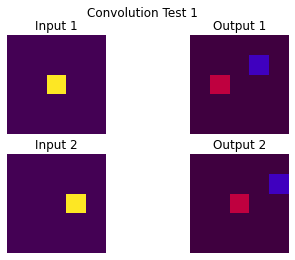

In [32]:
test_conv_1()

In [29]:
def test_conv_2():
    # Initialize the 'input' structure
    input_data = {}
    input_data['data'] = np.zeros((75, 4))

    input_data['data'][12, 0] = 1
    input_data['data'][12+25, 1] = 1
    input_data['data'][13+50, 2] = 1

    input_data['data'][0, 3] = 1
    input_data['data'][21, 3] = 1
    input_data['data'][12, 3] = 1
    input_data['data'][13, 3] = 1
    input_data['data'][13+25, 3] = 1
    input_data['data'][14+25, 3] = 1
    input_data['data'][24+50, 3] = 1

    input_data['width'] = 5
    input_data['height'] = 5
    input_data['channel'] = 3
    input_data['batch_size'] = 4

    # Initialize the 'conv_layer' structure
    conv_layer = {}
    conv_layer['type'] = 'CONV'
    conv_layer['num'] = 3
    conv_layer['k'] = 5
    conv_layer['stride'] = 1
    conv_layer['pad'] = 2

    # Initialize the 'params' structure
    params = {}
    params['w'] = np.zeros((75, 3))
    # What it does to red
    params['w'][13, 0] = 1.  # move image left by one pixel on red channel
    params['w'][11+5, 2] = 1.  # move image top-right dir on blue channel
    # What it does to green
    params['w'][12+25, 2] = 1.  # stay in place on blue
    params['w'][12+5+25, 1] = 1.    # move top on green
    # What it does to blue
    params['w'][12+50, 0] = 1.0  # stay in place
    params['w'][12+50, 1] = 1.0  # stay in place
    params['w'][12+50, 2] = 1.0  # stay in place
    # Bias
    params['b'] = np.array([0., 0.0, 0.])

    # Call the conv_layer_forward function (you would need to define this function in Python)
    output = conv_layer_forward(input_data, conv_layer, params)

    # Call the display_results function (you would need to define this function in Python)
    display_results(input_data, output, 'Convolution Test 2')


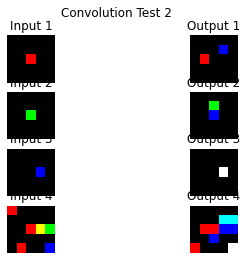

In [33]:
test_conv_2()

# Train LeNet

In [161]:
import numpy as np
from load_mnist import load_mnist
from init_convnet import init_convnet
from conv_net import conv_net
from utils import sgd_momentum, get_lr, get_lenet
import copy
from scipy.io import savemat

In [162]:
# Set random seeds
np.random.seed(100000)

# Network definition
layers = get_lenet()

In [163]:
# Loading data
fullset = False
xtrain, ytrain, xvalidate, yvalidate, xtest, ytest = load_mnist(fullset)
xtrain = np.hstack((xtrain, xvalidate))
ytrain = np.hstack((ytrain, yvalidate))
m_train = xtrain.shape[1]
batch_size = 100

In [164]:
# Parameters initialization
mu = 0.9
epsilon = 0.01
gamma = 0.0001
power = 0.75
weight_decay = 0.0005
w_lr = 1
b_lr = 2

In [165]:
test_interval = 500
display_interval = 50
snapshot = 500
max_iter = 2000


In [166]:
# Use the following to train from scratch
params = init_convnet(layers)

In [172]:
params_winc = copy.deepcopy(params)

# Training the network
new_order = np.random.permutation(m_train)
xtrain = xtrain[:, new_order]
ytrain = ytrain[:, new_order]
curr_batch = 0  

In [173]:
if curr_batch >= m_train:
    new_order = np.random.permutation(m_train)
    xtrain = xtrain[:, new_order]
    ytrain = ytrain[:, new_order]
    curr_batch = 0

x_batch = xtrain[:, curr_batch:curr_batch+batch_size]
y_batch = ytrain[:, curr_batch:curr_batch+batch_size]
curr_batch += batch_size

In [174]:
from conv_layer import conv_layer_forward, conv_layer_backward
from pooling_layer import pooling_layer_forward, pooling_layer_backward
from inner_product import inner_product_forward, inner_product_backward
from relu import relu_forward, relu_backward
from mlrloss import mlrloss

In [175]:
# cp, param_grad = conv_net(params, layers, x_batch, y_batch)

In [176]:
l = len(layers)
batch_size = layers[0]['batch_size']

In [177]:
l = len(layers)
assert layers[0]['type'] == 'DATA', 'first layer must be data layer'


In [185]:
data = x_batch
output = [{}]
output[0]['data'] = data
output[0]['height'] = layers[0]['height']
output[0]['width'] = layers[0]['width']
output[0]['channel'] = layers[0]['channel']
output[0]['batch_size'] = layers[0]['batch_size']
output[0]['diff'] = 0

In [186]:
#Manual conv forward

from utils import im2col_conv, col2im_conv, im2col_conv_batch

In [187]:

input_data = output[0]
layer=layers[1]
param = params[0]

In [194]:
conv_layer_forward(input_data,layer,param)

ValueError: setting an array element with a sequence.

In [188]:
h_in = input_data['height']
w_in = input_data['width']
c = input_data['channel']
batch_size = input_data['batch_size']
k = layer['k']
pad = layer['pad']
stride = layer['stride']
num = layer['num']

print(h_in)
print(w_in)

28
28


In [189]:
# resolve output shape
h_out = (h_in + 2*pad - k) // stride + 1
w_out = (w_in + 2*pad - k) // stride + 1

print(h_out)
print(w_out)

24
24


In [190]:
assert h_out == int(h_out), 'h_out is not integer'
assert w_out == int(w_out), 'w_out is not integer'

input_n = {
    'height': h_in,
    'width': w_in,
    'channel': c,
    'data': input_data['data'],
    'batch_size': batch_size
}

In [191]:
#empty output_data
output_data = np.zeros((h_out*w_out*num,batch_size))

#declare empty output to be filled in
conv_img = np.zeros((num,h_out,w_out))
print(conv_img.shape)

#prepare the data for convolution
pre_conv = im2col_conv_batch(input_n, layer, h_out, w_out)

#learning parameters
W = param['w']
b = param['b']


(20, 24, 24)


In [192]:
for batch in range(batch_size):
    #grab per image of batch
# batch = 0

    pre_conv_img = pre_conv[:,:,batch]

    #convolving over the number of filters
    for n in range(num):
        # print("n={}".format(n))
        for row in range(h_out):
            # print(row)
            for col in range(w_out):
                conv_img[n,row,col] = np.dot(pre_conv_img[:,row*w_out+col], W[:,n]) + b[:,n]

In [195]:
output_data[:,batch] = conv_img.reshape(1,h_out*w_out*num)

test_out = {
        'height': h_out,
        'width': w_out,
        'channel': num,
        'batch_size': batch_size,
        'data': output_data#np.zeros((h_out, w_out, num, batch_size)) # replace 'data' value with your implementation
    }

output.append(test_out)

In [ ]:
layer_type = layers[1]['type']
if layer_type == 'CONV':
    output.append(conv_layer_forward(output[0], layers[i], params[i-1]))
elif layer_type == 'POOLING':
    output.append(pooling_layer_forward(output[i-1], layers[i]))
elif layer_type == 'IP':
    output.append(inner_product_forward(output[i-1], layers[i], params[i-1]))
elif layer_type == 'RELU':
    output.append(relu_forward(output[i-1]))
else:
    raise Exception('Invalid layer type: %s' % layer_type)

In [155]:
#Below here is the test loop

In [171]:
for i in range(1, l-1):
    layer_type = layers[i]['type']
    if layer_type == 'CONV':
        output.append(conv_layer_forward(output[i-1], layers[i], params[i-1]))
    elif layer_type == 'POOLING':
        output.append(pooling_layer_forward(output[i-1], layers[i]))
    elif layer_type == 'IP':
        output.append(inner_product_forward(output[i-1], layers[i], params[i-1]))
    elif layer_type == 'RELU':
        output.append(relu_forward(output[i-1]))
    else:
        raise Exception('Invalid layer type: %s' % layer_type)

ValueError: setting an array element with a sequence.

# RELU Test Code


In [ ]:
#Test Data
input_data = {}
input_data['data'] = np.zeros((75, 4))

input_data['data'][12, 0] = 1
input_data['data'][12+25, 1] = 1
input_data['data'][13+50, 2] = 1

input_data['data'][0, 3] = 1
input_data['data'][21, 3] = 1
input_data['data'][12, 3] = 1
input_data['data'][13, 3] = 1
input_data['data'][13+25, 3] = 1
input_data['data'][14+25, 3] = 1
input_data['data'][24+50, 3] = 1

input_data['width'] = 5
input_data['height'] = 5
input_data['channel'] = 3
input_data['batch_size'] = 4

In [ ]:
output = {
    'height': input_data['height'], 
    'width': input_data['width'],
    'channel': input_data['channel'],
    'batch_size': input_data['batch_size'],
}

In [ ]:
def activate(x):
    if x > 0:
        return x
    else:
        return 0

In [ ]:
relu_activate = np.vectorize(activate)

In [ ]:
output['data'] = relu_activate(input_data['data'])

In [ ]:
output['data']

# Back Propagate Test

In [ ]:
# Initialize the 'input' structure
input_data = {}
input_data['data'] = np.zeros((25,2))
input_data['data'] = input_data['data'].T
input_data['data'].flat[5::3] = 1.0
input_data['data'].flat[6::3] = 0.5
input_data['data'] = input_data['data'].T
input_data['height'] = 25
input_data['width'] = 1
input_data['channel'] = 1
input_data['batch_size'] = 2

# Initialize the 'layer' structure
layer = {}
layer['type'] = 'IP'
layer['num'] = 25

# Initialize the 'params' structure
params = {}
params['w'] = np.eye(25)
params['w'].flat[:25*10] = 0
params['w'][1, 4] = 0.5
params['w'][2, 3] = 0.5
params['b'] = np.zeros((1,25))
params['b'][0,1] = 0.5
params['b'][0,3] = 0.5

output = inner_product_forward(input_data, layer, params)

In [ ]:
input_data['data'].shape #this is representing 2 5x5 images

In [ ]:
output['data'].shape

In [ ]:
params['w'].shape

In [ ]:
params['b'].shape

### The calling line
pg, input_od = inner_product_backward(output[i], output[i-1], layers[i], params[i-1])

We can assume the input_data here is the output from the previous layer for testing

layers is just defining properties of the layers but is not important for backpropagation I think

In [ ]:
test = np.zeros_like(params['w'])
test.shape

## Testing forward

### Convolution Testing Code

In [ ]:
# Initialize the 'input' structure
input_data = {}
input_data['data'] = np.zeros((75, 4))

input_data['data'][12, 0] = 1
input_data['data'][12+25, 1] = 1
input_data['data'][13+50, 2] = 1

input_data['data'][0, 3] = 1
input_data['data'][21, 3] = 1
input_data['data'][12, 3] = 1
input_data['data'][13, 3] = 1
input_data['data'][13+25, 3] = 1
input_data['data'][14+25, 3] = 1
input_data['data'][24+50, 3] = 1

input_data['width'] = 5
input_data['height'] = 5
input_data['channel'] = 3
input_data['batch_size'] = 4

# Initialize the 'conv_layer' structure
conv_layer = {}
conv_layer['type'] = 'CONV'
conv_layer['num'] = 3
conv_layer['k'] = 5
conv_layer['stride'] = 1
conv_layer['pad'] = 2

# Initialize the 'params' structure
params = {}
params['w'] = np.zeros((75, 3))
# What it does to red
params['w'][13, 0] = 1.  # move image left by one pixel on red channel
params['w'][11+5, 2] = 1.  # move image top-right dir on blue channel
# What it does to green
params['w'][12+25, 2] = 1.  # stay in place on blue
params['w'][12+5+25, 1] = 1.    # move top on green
# What it does to blue
params['w'][12+50, 0] = 1.0  # stay in place
params['w'][12+50, 1] = 1.0  # stay in place
params['w'][12+50, 2] = 1.0  # stay in place
# Bias
params['b'] = np.array([0., 0.0, 0.])

In [ ]:
layer = conv_layer
input_data = input_data
param = params

In [ ]:
#from forward_conv_layer function
h_in = input_data['height']
w_in = input_data['width']
c = input_data['channel']
batch_size = input_data['batch_size']
k = layer['k']
pad = layer['pad']
stride = layer['stride']
num = layer['num']

# resolve output shape
h_out = (h_in + 2*pad - k) // stride + 1
w_out = (w_in + 2*pad - k) // stride + 1

assert h_out == int(h_out), 'h_out is not integer'
assert w_out == int(w_out), 'w_out is not integer'

input_n = {
    'height': h_in,
    'width': w_in,
    'channel': c,
    'data': input_data['data'],
    'batch_size': batch_size
}

In [ ]:
pre_conv = im2col_conv_batch(input_n, layer, h_out, w_out)

What the above function does is slide the kernel mask around and grab all the relevant pixels that will be used in the convolution and create a bunch of columns that will make up an array for the image. 

Convolution can easily be performed across the columns and populate a 5x5 across the depth of the filters, given by the 'num' variable.

In [ ]:
pre_conv.shape

In [ ]:
pre_conv[:,:,1] #the output of this agrees with what I should be seeing

This is the 5x5 image for a batch of 2 converted into columns for computation

In [ ]:
#declare empty output to be filled in
conv_img = np.zeros((num,h_out,w_out))
output_data = np.zeros((h_out*w_out*num,batch_size))

In [ ]:
conv_img.shape #this is the convolved image to a depth

In [ ]:
output_data.shape #this is the convolved images arranged as column vectors

In [ ]:
W = param['w']
b = param['b']

In [ ]:
W[:,0].shape

In [ ]:
#original loop
for batch in range(batch_size):
    #grab per image of batch
    pre_conv_img = pre_conv[:,:,batch]

    #convolving over the number of filters
    for n in range(num):
        for row in range(h_out):
            for col in range(w_out): 
                conv_img[n,row,col] = np.dot(pre_conv_img[row*5+col].T, W[:,n]) #+ b[n]

#     output_data[:,batch] = conv_img.reshape(1,h_out*w_out*num)


In [ ]:
pre_conv_img = pre_conv[:,:,1]

#convolving over the number of filters
for n in range(num):
    for row in range(h_out):
        for col in range(w_out): 
            conv_img[n,row,col] = np.dot(pre_conv_img[row*5+col], W[:,n]) + b[n]
            


In [ ]:
test=pre_conv[:,:,0]

In [ ]:
test[:,0].T.shape

## Test Display

In [ ]:
fig, ax = plt.subplots(input_data['batch_size'], 2)
for batch in range(input_data['batch_size']):
#         # outputs
#         img1 = output['data'][:,batch].reshape(output['channel'], output['height'], output['width'])
#         img1 = np.transpose(img1, (1, 2, 0))
#         ax[batch, 1].imshow(img1)
#         ax[batch, 1].set_title(f'Output {batch + 1}')
#         ax[batch, 1].set_axis_off()

    # inputs
    imgin1 = input_data['data'][:,batch].reshape(input_data['channel'], input_data['height'], input_data['width'])
    imgin1 = np.transpose(imgin1, (1, 2, 0))
    ax[batch, 0].imshow(imgin1)
    ax[batch, 0].set_title(f'Input {batch + 1}')
    ax[batch, 0].set_axis_off()


## Test Code

In [ ]:
arr = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])
print(arr)

#2D slicing
mtx = arr[:2, 1:4]

print(mtx)


print(mtx.shape)

ar = mtx.reshape(1,mtx.shape[0]*mtx.shape[1])[0]

print(ar)

print(np.max(mtx))


### Padding the matrix

In [ ]:
test = input_data['data'][:,0].reshape(c, h_in, w_in)[2]
test

In [ ]:
pad_test = np.pad(test,1)
pad_test

In [ ]:
pad=0

In [ ]:
pad_img = np.zeros((c,pad*2+h_in,pad*2+w_in))
pad_img

In [ ]:
for chan in range(c):
    pad_img[chan] = np.pad(img[chan],pad)

In [ ]:
pad_img.shape

### Navigating the matrix

In [ ]:
for j in range(0,pad_img.shape[1],stride): #stride is 2
        
        #go across columns with i
        for i in range(0,pad_img.shape[2], stride):
            print(j,i)